El presente código se divide en dos secciones. En la primera, se hace el análisis de texto de múltiples noticias de 7 medios de forma individual. En la segunda, el análisis se hace para cada medio en general tomando sus noticias en conjunto. El código arroja los histogramas de frecuencia de las palabras, y genera grafos, tanto bigramas como skipgramas (el *skip* utilizado fue de 2). El código permite obtener diferentes medidas de centralidad de estos grafos, además de otras propiedades topológicas y estadísticas útiles en el análisis de redes textuales.

IMPORTANTE: El código toma los archivos dados en la carpeta 'Medios' (adjuntada de manera conjunta con este notebook). Antes de correr el código, verificar la ruta del directorio (**folder_path**)

# **ANÁLISIS DE NOTICIAS INDIVIDUALES**

## EL TIEMPO:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.1 MB/s eta 0:00:00


**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/El tiempo'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 6))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

/content/drive/MyDrive/Medios/El tiempo/Eltiempo24.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo23.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo22.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo21.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo20.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo19.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo18.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo17.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo16.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo1.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo2.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo3.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo4.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo5.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo6.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo7.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo8.txt
/content/drive/MyDrive/Medios/El tiempo/Eltiempo9.txt
/content/drive/MyDr

### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  # print(f'PARA {filename}')
  # print('Centralidad de grado:')
  # print(degree_centrality)
  # print('Centralidad de intermediación')
  # print(betweenness_centrality)
  # print('Centralidad de cercanía')
  # print(closeness_centrality)
  # print('Centralidad de vector propio')
  # print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/El Tiempo/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

               Centralidad de Grado                                          \
                              count      mean       std       min       25%   
Noticia                                                                       
Eltiempo1.txt                 116.0  0.022039  0.011492  0.017391  0.017391   
Eltiempo10.txt                140.0  0.017780  0.009151  0.007194  0.014388   
Eltiempo11.txt                276.0  0.009196  0.005239  0.007273  0.007273   
Eltiempo12.txt                516.0  0.005599  0.004728  0.001942  0.003883   
Eltiempo13.txt                551.0  0.005055  0.004339  0.001818  0.003636   
Eltiempo14.txt                520.0  0.005180  0.003908  0.001927  0.003854   
Eltiempo15.txt                154.0  0.016213  0.007916  0.013072  0.013072   
Eltiempo16.txt                130.0  0.020274  0.009956  0.007752  0.015504   
Eltiempo17.txt                234.0  0.011225  0.008498  0.004292  0.008584   
Eltiempo18.txt                151.0  0.016336  0.007

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Eltiempo1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.794505   
Centralidad de Cercania                    0.475226   
Centralidad de Vector Propio               0.702594   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.794505   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.436871   
Centralidad de Vector Propio                        0.649801   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.475226   
Centralidad de Intermediacion                 0.436871   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.777423   

                               Centralidad de Vector Propio  
Centrali

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'Eltiempo24.txt': {'Tamaño': 67, 'Densidad': 0.03618272274988693}, 'Eltiempo23.txt': {'Tamaño': 134, 'Densidad': 0.01952642801032432}, 'Eltiempo22.txt': {'Tamaño': 221, 'Densidad': 0.012505141916906623}, 'Eltiempo21.txt': {'Tamaño': 215, 'Densidad': 0.012040860682460335}, 'Eltiempo20.txt': {'Tamaño': 170, 'Densidad': 0.016219979115906717}, 'Eltiempo19.txt': {'Tamaño': 224, 'Densidad': 0.011210762331838564}, 'Eltiempo18.txt': {'Tamaño': 151, 'Densidad': 0.016335540838852098}, 'Eltiempo17.txt': {'Tamaño': 234, 'Densidad': 0.011224826675470452}, 'Eltiempo16.txt': {'Tamaño': 130, 'Densidad': 0.020274299344066785}, 'Eltiempo1.txt': {'Tamaño': 116, 'Densidad': 0.022038980509745128}, 'Eltiempo2.txt': {'Tamaño': 117, 'Densidad': 0.02180960801650457}, 'Eltiempo3.txt': {'Tamaño': 276, 'Densidad': 0.010355731225296443}, 'Eltiempo4.txt': {'Tamaño': 212, 'Densidad': 0.012697844943217384}, 'Eltiempo5.txt': {'Tamaño': 224, 'Densidad': 0.011010570147341447}, 'Eltiempo6.txt': {'Tamaño': 154, 'Densidad

#### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

          Noticia    Palabra  Centralidad de Grado  \
0  Eltiempo24.txt  sebastian              0.212121   
1  Eltiempo24.txt   villegas              0.136364   
2  Eltiempo24.txt    asesino              0.075758   
3  Eltiempo24.txt   isabella              0.227273   
4  Eltiempo24.txt       mesa              0.166667   

   Centralidad de Intermediacion  Centralidad de Cercania  \
0                       0.133838                 0.461538   
1                       0.018899                 0.425806   
2                       0.003352                 0.368715   
3                       0.076860                 0.420382   
4                       0.033629                 0.395210   

   Centralidad de Vector Propio  
0                      0.237058  
1                      0.206523  
2                      0.125262  
3                      0.272917  
4                      0.209570  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/El Tiempo/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

               Centralidad de Grado                                          \
                              count      mean       std       min       25%   
Noticia                                                                       
Eltiempo1.txt                 116.0  0.066417  0.034733  0.034783  0.052174   
Eltiempo10.txt                140.0  0.053135  0.026662  0.021583  0.043165   
Eltiempo11.txt                276.0  0.027457  0.015743  0.014545  0.021818   
Eltiempo12.txt                516.0  0.016701  0.014155  0.005825  0.011650   
Eltiempo13.txt                551.0  0.015139  0.012839  0.005455  0.010909   
Eltiempo14.txt                520.0  0.015496  0.011361  0.005780  0.011561   
Eltiempo15.txt                154.0  0.048468  0.023005  0.032680  0.039216   
Eltiempo16.txt                130.0  0.060346  0.027690  0.023256  0.046512   
Eltiempo17.txt                234.0  0.033418  0.024051  0.012876  0.025751   
Eltiempo18.txt                151.0  0.049536  0.023

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Eltiempo1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.894876   
Centralidad de Cercania                    0.654970   
Centralidad de Vector Propio               0.842584   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.894876   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.552578   
Centralidad de Vector Propio                        0.671687   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.654970   
Centralidad de Intermediacion                 0.552578   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.887150   

                               Centralidad de Vector Propio  
Centrali

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_s)

{'Eltiempo24.txt': {'Tamaño': 67, 'Densidad': 0.11035730438715513}, 'Eltiempo23.txt': {'Tamaño': 134, 'Densidad': 0.0591403882841432}, 'Eltiempo22.txt': {'Tamaño': 221, 'Densidad': 0.03735088440970794}, 'Eltiempo21.txt': {'Tamaño': 215, 'Densidad': 0.03660073896978917}, 'Eltiempo20.txt': {'Tamaño': 170, 'Densidad': 0.048590323703445876}, 'Eltiempo19.txt': {'Tamaño': 224, 'Densidad': 0.0341527866752082}, 'Eltiempo18.txt': {'Tamaño': 151, 'Densidad': 0.0495364238410596}, 'Eltiempo17.txt': {'Tamaño': 234, 'Densidad': 0.03341770294559994}, 'Eltiempo16.txt': {'Tamaño': 130, 'Densidad': 0.060345855694692904}, 'Eltiempo1.txt': {'Tamaño': 116, 'Densidad': 0.0664167916041979}, 'Eltiempo2.txt': {'Tamaño': 117, 'Densidad': 0.06542882404951371}, 'Eltiempo3.txt': {'Tamaño': 276, 'Densidad': 0.030408432147562583}, 'Eltiempo4.txt': {'Tamaño': 212, 'Densidad': 0.038987749262273094}, 'Eltiempo5.txt': {'Tamaño': 224, 'Densidad': 0.03343209481101858}, 'Eltiempo6.txt': {'Tamaño': 154, 'Densidad': 0.045072

## EL COLOMBIANO:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/El colombiano'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

#print(read_text_file("/content/eltiempo9.txt"))

/content/drive/MyDrive/Medios/El colombiano/ElColombiano1.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano2.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano3.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano4.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano5.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano6.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano7.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano8.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano9.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano10.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano11.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano12.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano13.txt
/content/drive/MyDrive/Medios/El colombiano/ElColombiano14.txt


### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/El Colombiano/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

                   Centralidad de Grado                                \
                                  count      mean       std       min   
Noticia                                                                 
ElColombiano1.txt                  79.0  0.030185  0.013623  0.012821   
ElColombiano10.txt                208.0  0.012588  0.007008  0.004831   
ElColombiano11.txt                289.0  0.009251  0.006940  0.003472   
ElColombiano12.txt                161.0  0.016460  0.007896  0.012500   
ElColombiano13.txt                128.0  0.020177  0.011681  0.007874   
ElColombiano14.txt                170.0  0.014271  0.006614  0.005917   
ElColombiano2.txt                 131.0  0.020787  0.012057  0.007692   
ElColombiano3.txt                 219.0  0.012316  0.006801  0.004587   
ElColombiano4.txt                 219.0  0.012316  0.006801  0.004587   
ElColombiano5.txt                 180.0  0.013222  0.005961  0.005587   
ElColombiano6.txt                 127.0  0.018373  

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para ElColombiano1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.657519   
Centralidad de Cercania                    0.468169   
Centralidad de Vector Propio               0.735949   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.657519   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.259561   
Centralidad de Vector Propio                        0.421387   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.468169   
Centralidad de Intermediacion                 0.259561   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.652288   

                               Centralidad de Vector Propio  
Cent

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'ElColombiano1.txt': {'Tamaño': 79, 'Densidad': 0.03018500486854917}, 'ElColombiano2.txt': {'Tamaño': 131, 'Densidad': 0.020786846741045216}, 'ElColombiano3.txt': {'Tamaño': 219, 'Densidad': 0.01231619957270328}, 'ElColombiano4.txt': {'Tamaño': 219, 'Densidad': 0.01231619957270328}, 'ElColombiano5.txt': {'Tamaño': 180, 'Densidad': 0.013221601489757914}, 'ElColombiano6.txt': {'Tamaño': 127, 'Densidad': 0.01837270341207349}, 'ElColombiano7.txt': {'Tamaño': 356, 'Densidad': 0.0073112834309226144}, 'ElColombiano8.txt': {'Tamaño': 116, 'Densidad': 0.02638680659670165}, 'ElColombiano9.txt': {'Tamaño': 116, 'Densidad': 0.02638680659670165}, 'ElColombiano10.txt': {'Tamaño': 208, 'Densidad': 0.012588257153474544}, 'ElColombiano11.txt': {'Tamaño': 289, 'Densidad': 0.009251249519415609}, 'ElColombiano12.txt': {'Tamaño': 161, 'Densidad': 0.016459627329192546}, 'ElColombiano13.txt': {'Tamaño': 128, 'Densidad': 0.020177165354330708}, 'ElColombiano14.txt': {'Tamaño': 170, 'Densidad': 0.0142707970762

### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

             Noticia      Palabra  Centralidad de Grado  \
0  ElColombiano1.txt         tras              0.038462   
1  ElColombiano1.txt  feminicidio              0.256410   
2  ElColombiano1.txt        diana              0.102564   
3  ElColombiano1.txt     carolina              0.115385   
4  ElColombiano1.txt        serna              0.128205   

   Centralidad de Intermediacion  Centralidad de Cercania  \
0                       0.000000                 0.296578   
1                       0.196314                 0.410526   
2                       0.011168                 0.357798   
3                       0.014102                 0.359447   
4                       0.050085                 0.390000   

   Centralidad de Vector Propio  
0                      0.073085  
1                      0.287356  
2                      0.179400  
3                      0.190173  
4                      0.214766  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/El Colombiano/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

                   Centralidad de Grado                                \
                                  count      mean       std       min   
Noticia                                                                 
ElColombiano1.txt                  79.0  0.091853  0.040356  0.038462   
ElColombiano10.txt                208.0  0.036929  0.019835  0.014493   
ElColombiano11.txt                289.0  0.027345  0.019479  0.010417   
ElColombiano12.txt                161.0  0.050621  0.025313  0.025000   
ElColombiano13.txt                128.0  0.061270  0.035199  0.023622   
ElColombiano14.txt                170.0  0.042882  0.018908  0.017751   
ElColombiano2.txt                 131.0  0.062478  0.036257  0.023077   
ElColombiano3.txt                 219.0  0.037535  0.021495  0.013761   
ElColombiano4.txt                 219.0  0.037535  0.021495  0.013761   
ElColombiano5.txt                 180.0  0.039913  0.019281  0.016760   
ElColombiano6.txt                 127.0  0.055493  

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para ElColombiano1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.783990   
Centralidad de Cercania                    0.595176   
Centralidad de Vector Propio               0.804624   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.783990   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.396046   
Centralidad de Vector Propio                        0.463110   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.595176   
Centralidad de Intermediacion                 0.396046   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.813195   

                               Centralidad de Vector Propio  
Cent

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }

## EL ESPECTADOR:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/El espectador'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

#print(read_text_file("/content/eltiempo9.txt"))

/content/drive/MyDrive/Medios/El espectador/Elespectador3.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador4.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador5.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador6.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador7.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador8.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador9.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador10.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador11.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador12.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador13.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador14.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador15.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador16.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador1.txt
/content/drive/MyDrive/Medios/El espectador/Elespectador2.txt


### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/El Espectador/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

                   Centralidad de Grado                                \
                                  count      mean       std       min   
Noticia                                                                 
Elespectador1.txt                 203.0  0.012291  0.006080  0.004950   
Elespectador10.txt                204.0  0.012170  0.005711  0.009852   
Elespectador11.txt                206.0  0.012692  0.007598  0.009756   
Elespectador12.txt                507.0  0.005800  0.004561  0.001976   
Elespectador13.txt                145.0  0.017912  0.010244  0.013889   
Elespectador14.txt                126.0  0.018286  0.007426  0.016000   
Elespectador15.txt                400.0  0.006717  0.004906  0.002506   
Elespectador16.txt                274.0  0.009171  0.004747  0.007326   
Elespectador2.txt                 394.0  0.006665  0.004270  0.005089   
Elespectador3.txt                 383.0  0.007163  0.005164  0.005236   
Elespectador4.txt                 601.0  0.004554  

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Elespectador1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.658439   
Centralidad de Cercania                    0.413792   
Centralidad de Vector Propio               0.553708   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.658439   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.378606   
Centralidad de Vector Propio                        0.347758   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.413792   
Centralidad de Intermediacion                 0.378606   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.552770   

                               Centralidad de Vector Propio  
Cent

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'Elespectador3.txt': {'Tamaño': 383, 'Densidad': 0.0071630691837655325}, 'Elespectador4.txt': {'Tamaño': 601, 'Densidad': 0.0045535219079312255}, 'Elespectador5.txt': {'Tamaño': 315, 'Densidad': 0.008998079061773329}, 'Elespectador6.txt': {'Tamaño': 237, 'Densidad': 0.009440034327397553}, 'Elespectador7.txt': {'Tamaño': 494, 'Densidad': 0.006093404833663187}, 'Elespectador8.txt': {'Tamaño': 185, 'Densidad': 0.013807285546415981}, 'Elespectador9.txt': {'Tamaño': 325, 'Densidad': 0.008395061728395062}, 'Elespectador10.txt': {'Tamaño': 204, 'Densidad': 0.012170385395537525}, 'Elespectador11.txt': {'Tamaño': 206, 'Densidad': 0.01269239876864788}, 'Elespectador12.txt': {'Tamaño': 507, 'Densidad': 0.005800219847042589}, 'Elespectador13.txt': {'Tamaño': 145, 'Densidad': 0.017911877394636014}, 'Elespectador14.txt': {'Tamaño': 126, 'Densidad': 0.018285714285714287}, 'Elespectador15.txt': {'Tamaño': 400, 'Densidad': 0.0067167919799498745}, 'Elespectador16.txt': {'Tamaño': 274, 'Densidad': 0.009

#### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

             Noticia       Palabra  Centralidad de Grado  \
0  Elespectador3.txt      stefanny              0.075916   
1  Elespectador3.txt      barranco              0.083770   
2  Elespectador3.txt         cinco              0.013089   
3  Elespectador3.txt  feminicidios              0.123037   
4  Elespectador3.txt       centros              0.065445   

   Centralidad de Intermediacion  Centralidad de Cercania  \
0                       0.066283                 0.432127   
1                       0.052417                 0.434585   
2                       0.000000                 0.350781   
3                       0.119847                 0.431638   
4                       0.029983                 0.374143   

   Centralidad de Vector Propio  
0                      0.211502  
1                      0.249401  
2                      0.066554  
3                      0.225928  
4                      0.110536  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/El Espectador/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

                   Centralidad de Grado                                \
                                  count      mean       std       min   
Noticia                                                                 
Elespectador1.txt                 203.0  0.036921  0.018181  0.014851   
Elespectador10.txt                204.0  0.036318  0.017070  0.024631   
Elespectador11.txt                206.0  0.037698  0.021070  0.019512   
Elespectador12.txt                507.0  0.017424  0.013554  0.007905   
Elespectador13.txt                145.0  0.052969  0.029200  0.027778   
Elespectador14.txt                126.0  0.054857  0.022846  0.032000   
Elespectador15.txt                400.0  0.020301  0.014621  0.007519   
Elespectador16.txt                274.0  0.027593  0.013948  0.014652   
Elespectador2.txt                 394.0  0.020201  0.013121  0.012723   
Elespectador3.txt                 383.0  0.022145  0.017198  0.013089   
Elespectador4.txt                 601.0  0.013633  

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Elespectador1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.847281   
Centralidad de Cercania                    0.539469   
Centralidad de Vector Propio               0.735003   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.847281   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.462010   
Centralidad de Vector Propio                        0.558271   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.539469   
Centralidad de Intermediacion                 0.462010   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.766910   

                               Centralidad de Vector Propio  
Cent

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }

## VOLCÁNICAS:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/Volcanicas'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

#print(read_text_file("/content/eltiempo9.txt"))

/content/drive/MyDrive/Medios/Volcanicas/Volcanicas4.txt
/content/drive/MyDrive/Medios/Volcanicas/Volcanicas3.txt
/content/drive/MyDrive/Medios/Volcanicas/Volcanicas2.txt
/content/drive/MyDrive/Medios/Volcanicas/Volcanicas1.txt


### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/Volcánicas/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

                Centralidad de Grado                                          \
                               count      mean       std       min       25%   
Noticia                                                                        
Volcanicas1.txt                472.0  0.006513  0.006158  0.002123  0.004246   
Volcanicas2.txt                141.0  0.017832  0.011314  0.007143  0.014286   
Volcanicas3.txt                225.0  0.011865  0.008440  0.004464  0.008929   
Volcanicas4.txt                314.0  0.008852  0.008400  0.006390  0.006390   

                                              Centralidad de Intermediacion  \
                      50%       75%       max                         count   
Noticia                                                                       
Volcanicas1.txt  0.004246  0.006369  0.050955                         472.0   
Volcanicas2.txt  0.014286  0.014286  0.121429                         141.0   
Volcanicas3.txt  0.008929  0.008929  0.09375

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Volcanicas1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.924279   
Centralidad de Cercania                    0.559441   
Centralidad de Vector Propio               0.820022   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.924279   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.507389   
Centralidad de Vector Propio                        0.819740   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.559441   
Centralidad de Intermediacion                 0.507389   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.736584   

                               Centralidad de Vector Propio  
Centra

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'Volcanicas4.txt': {'Tamaño': 314, 'Densidad': 0.008852078712276917}, 'Volcanicas3.txt': {'Tamaño': 225, 'Densidad': 0.011865079365079365}, 'Volcanicas2.txt': {'Tamaño': 141, 'Densidad': 0.017831813576494427}, 'Volcanicas1.txt': {'Tamaño': 472, 'Densidad': 0.0065133685990859695}}


#### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

           Noticia       Palabra  Centralidad de Grado  \
0  Volcanicas4.txt      colombia              0.076677   
1  Volcanicas4.txt        alerta              0.012780   
2  Volcanicas4.txt        maxima              0.015974   
3  Volcanicas4.txt  feminicidios              0.242812   
4  Volcanicas4.txt            va              0.035144   

   Centralidad de Intermediacion  Centralidad de Cercania  \
0                       0.018601                 0.365654   
1                       0.000025                 0.325702   
2                       0.000201                 0.339112   
3                       0.221296                 0.467164   
4                       0.002936                 0.374850   

   Centralidad de Vector Propio  
0                      0.130909  
1                      0.042281  
2                      0.054763  
3                      0.382241  
4                      0.092676  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/Volcánicas/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

                Centralidad de Grado                                          \
                               count      mean       std       min       25%   
Noticia                                                                        
Volcanicas1.txt                472.0  0.019666  0.018903  0.006369  0.012739   
Volcanicas2.txt                141.0  0.052178  0.030639  0.021429  0.042857   
Volcanicas3.txt                225.0  0.034563  0.023149  0.017857  0.026786   
Volcanicas4.txt                314.0  0.026414  0.023147  0.012780  0.019169   

                                              Centralidad de Intermediacion  \
                      50%       75%       max                         count   
Noticia                                                                       
Volcanicas1.txt  0.012739  0.019108  0.188960                         472.0   
Volcanicas2.txt  0.042857  0.042857  0.328571                         141.0   
Volcanicas3.txt  0.026786  0.026786  0.24107

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Volcanicas1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.943882   
Centralidad de Cercania                    0.678650   
Centralidad de Vector Propio               0.911605   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.943882   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.584089   
Centralidad de Vector Propio                        0.850368   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.678650   
Centralidad de Intermediacion                 0.584089   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.853676   

                               Centralidad de Vector Propio  
Centra

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }

## LA SILLA VACÍA:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/La silla vacía'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

#print(read_text_file("/content/eltiempo9.txt"))

/content/drive/MyDrive/Medios/La silla vacía/Silla1.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla2.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla3.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla4.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla5.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla6.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla7.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla11.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla12.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla13.txt
/content/drive/MyDrive/Medios/La silla vacía/Silla14.txt


### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/La Silla Vacía/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

            Centralidad de Grado                                          \
                           count      mean       std       min       25%   
Noticia                                                                    
Silla1.txt                 392.0  0.007581  0.006943  0.002558  0.005115   
Silla11.txt                 76.0  0.032982  0.016217  0.013333  0.026667   
Silla12.txt                 74.0  0.036653  0.020420  0.027397  0.027397   
Silla13.txt                565.0  0.004751  0.003414  0.001773  0.003546   
Silla14.txt                117.0  0.019304  0.007217  0.008621  0.017241   
Silla2.txt                 276.0  0.008775  0.006538  0.003636  0.007273   
Silla3.txt                 336.0  0.007516  0.006141  0.002985  0.005970   
Silla4.txt                 279.0  0.009489  0.007065  0.003597  0.007194   
Silla5.txt                  61.0  0.040437  0.014421  0.033333  0.033333   
Silla6.txt                 230.0  0.011088  0.005794  0.004367  0.008734   
Silla7.txt  

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Silla1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.934119   
Centralidad de Cercania                    0.496525   
Centralidad de Vector Propio               0.693546   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.934119   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.492822   
Centralidad de Vector Propio                        0.714384   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.496525   
Centralidad de Intermediacion                 0.492822   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.632886   

                               Centralidad de Vector Propio  
Centralidad

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'Silla1.txt': {'Tamaño': 392, 'Densidad': 0.007581293386919985}, 'Silla2.txt': {'Tamaño': 276, 'Densidad': 0.008774703557312254}, 'Silla3.txt': {'Tamaño': 336, 'Densidad': 0.007515991471215352}, 'Silla4.txt': {'Tamaño': 279, 'Densidad': 0.00948918284727057}, 'Silla5.txt': {'Tamaño': 61, 'Densidad': 0.040437158469945354}, 'Silla6.txt': {'Tamaño': 230, 'Densidad': 0.011087905828745016}, 'Silla7.txt': {'Tamaño': 383, 'Densidad': 0.007573168564515467}, 'Silla11.txt': {'Tamaño': 76, 'Densidad': 0.03298245614035088}, 'Silla12.txt': {'Tamaño': 74, 'Densidad': 0.036653091447611995}, 'Silla13.txt': {'Tamaño': 565, 'Densidad': 0.004751145421452331}, 'Silla14.txt': {'Tamaño': 117, 'Densidad': 0.019304450338933098}}


#### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

      Noticia Palabra  Centralidad de Grado  Centralidad de Intermediacion  \
0  Silla1.txt    vida              0.061381                       0.022707   
1  Silla1.txt  muerte              0.025575                       0.012166   
2  Silla1.txt  lineas              0.191816                       0.180831   
3  Silla1.txt   rojas              0.148338                       0.090851   
4  Silla1.txt   zonas              0.056266                       0.012594   

   Centralidad de Cercania  Centralidad de Vector Propio  
0                 0.402678                      0.125803  
1                 0.359375                      0.059386  
2                 0.485714                      0.343449  
3                 0.460542                      0.300883  
4                 0.396552                      0.130867  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/La Silla Vacía/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

            Centralidad de Grado                                          \
                           count      mean       std       min       25%   
Noticia                                                                    
Silla1.txt                 392.0  0.022274  0.020289  0.010230  0.015345   
Silla11.txt                 76.0  0.097193  0.047743  0.040000  0.080000   
Silla12.txt                 74.0  0.107738  0.057555  0.054795  0.082192   
Silla13.txt                565.0  0.014266  0.010533  0.005319  0.010638   
Silla14.txt                117.0  0.058061  0.023237  0.025862  0.051724   
Silla2.txt                 276.0  0.026271  0.020399  0.010909  0.021818   
Silla3.txt                 336.0  0.022406  0.018039  0.014925  0.017910   
Silla4.txt                 279.0  0.028493  0.022905  0.010791  0.021583   
Silla5.txt                  61.0  0.119126  0.043123  0.066667  0.100000   
Silla6.txt                 230.0  0.033150  0.017481  0.013100  0.026201   
Silla7.txt  

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Silla1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.947298   
Centralidad de Cercania                    0.651896   
Centralidad de Vector Propio               0.873389   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.947298   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.573759   
Centralidad de Vector Propio                        0.793336   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.651896   
Centralidad de Intermediacion                 0.573759   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.845989   

                               Centralidad de Vector Propio  
Centralidad

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }

## LA CASA DE LA MUJER:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/Casa de la mujer'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

#print(read_text_file("/content/eltiempo9.txt"))

/content/drive/MyDrive/Medios/Casa de la mujer/casa1.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa43.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa44.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa45.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa46.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa47.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa48.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa49.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa5.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa50.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa51.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa52.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa53.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa54.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa55.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa56.txt
/content/drive/MyDrive/Medios/Casa de la mujer/casa57.txt
/content/drive/M

### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/La Casa de la Mujer/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

           Centralidad de Grado                                          \
                          count      mean       std       min       25%   
Noticia                                                                   
casa1.txt                 441.0  0.006287  0.005069  0.002273  0.004545   
casa10.txt                251.0  0.009880  0.004176  0.004000  0.008000   
casa11.txt                149.0  0.017595  0.015146  0.013514  0.013514   
casa12.txt                 98.0  0.025668  0.017279  0.010309  0.020619   
casa13.txt                201.0  0.012687  0.006800  0.005000  0.010000   
...                         ...       ...       ...       ...       ...   
casa7.txt                 145.0  0.017337  0.007506  0.013889  0.013889   
casa70.txt                192.0  0.013416  0.007180  0.005236  0.010471   
casa71.txt                239.0  0.010935  0.005456  0.008403  0.008403   
casa8.txt                 256.0  0.009620  0.006249  0.003922  0.007843   
casa9.txt                

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para casa1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.910922   
Centralidad de Cercania                    0.466904   
Centralidad de Vector Propio               0.687963   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.910922   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.466671   
Centralidad de Vector Propio                        0.597509   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.466904   
Centralidad de Intermediacion                 0.466671   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.604900   

                               Centralidad de Vector Propio  
Centralidad 

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'casa1.txt': {'Tamaño': 441, 'Densidad': 0.006287363430220573}, 'casa43.txt': {'Tamaño': 250, 'Densidad': 0.010313253012048192}, 'casa44.txt': {'Tamaño': 664, 'Densidad': 0.004633920296570899}, 'casa45.txt': {'Tamaño': 118, 'Densidad': 0.02071563088512241}, 'casa46.txt': {'Tamaño': 119, 'Densidad': 0.02335849594074918}, 'casa47.txt': {'Tamaño': 188, 'Densidad': 0.0132552053703493}, 'casa48.txt': {'Tamaño': 287, 'Densidad': 0.008698618454716017}, 'casa49.txt': {'Tamaño': 116, 'Densidad': 0.020389805097451273}, 'casa5.txt': {'Tamaño': 127, 'Densidad': 0.018997625296837895}, 'casa50.txt': {'Tamaño': 232, 'Densidad': 0.01238990894163308}, 'casa51.txt': {'Tamaño': 77, 'Densidad': 0.031784005468216}, 'casa52.txt': {'Tamaño': 402, 'Densidad': 0.007059465763452066}, 'casa53.txt': {'Tamaño': 444, 'Densidad': 0.005795863583673968}, 'casa54.txt': {'Tamaño': 219, 'Densidad': 0.01265133425495371}, 'casa55.txt': {'Tamaño': 98, 'Densidad': 0.025036818851251842}, 'casa56.txt': {'Tamaño': 106, 'Densid

#### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

     Noticia      Palabra  Centralidad de Grado  \
0  casa1.txt  feminicidio              0.165909   
1  casa1.txt       centro              0.052273   
2  casa1.txt    comercial              0.068182   
3  casa1.txt      santafe              0.029545   
4  casa1.txt        cinco              0.027273   

   Centralidad de Intermediacion  Centralidad de Cercania  \
0                       0.159655                 0.425532   
1                       0.022777                 0.359184   
2                       0.041976                 0.372566   
3                       0.012639                 0.361248   
4                       0.011449                 0.349206   

   Centralidad de Vector Propio  
0                      0.394121  
1                      0.121389  
2                      0.149070  
3                      0.086139  
4                      0.069480  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/La Casa de la Mujer/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

           Centralidad de Grado                                          \
                          count      mean       std       min       25%   
Noticia                                                                   
casa1.txt                 441.0  0.019037  0.014818  0.006818  0.013636   
casa10.txt                251.0  0.029992  0.012701  0.012000  0.024000   
casa11.txt                149.0  0.051877  0.044107  0.027027  0.040541   
casa12.txt                 98.0  0.074690  0.046579  0.030928  0.061856   
casa13.txt                201.0  0.039005  0.021818  0.015000  0.030000   
...                         ...       ...       ...       ...       ...   
casa7.txt                 145.0  0.052778  0.024530  0.027778  0.041667   
casa70.txt                192.0  0.041012  0.022510  0.015707  0.031414   
casa71.txt                239.0  0.033086  0.016741  0.021008  0.025210   
casa8.txt                 256.0  0.028523  0.017519  0.011765  0.023529   
casa9.txt                

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para casa1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.926407   
Centralidad de Cercania                    0.598317   
Centralidad de Vector Propio               0.857338   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.926407   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.518527   
Centralidad de Vector Propio                        0.737242   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.598317   
Centralidad de Intermediacion                 0.518527   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.815196   

                               Centralidad de Vector Propio  
Centralidad 

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }

## PUBLIMETRO:

### Procesamiento, creación y exportación de gráficas

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO

import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive    #SECCIÓN PARA MONTAR EL DIRECTORIO 'MEDIOS' DESDE EL DRIVE
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [unidecode(word) for word in words]

    return words

def word_frequencies(words):
    return Counter(words)

folder_path = '/content/drive/MyDrive/Medios/Publimetro'  #Ruta del archivo que vamos a analizar (HAY QUE CREAR UN ACCESO DIRECTO DE LA CARPETA EN NUESTRA RESPECTIVA UNIDAD)

# Lista con todos los archivos .txt en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Procesamiento de solo archivos .txt
        file_path = os.path.join(folder_path, file_name)  # Ruta completa del archivo
        text = read_text_file(file_path)
        words = preprocess_text(text)
        frequencies = word_frequencies(words)

        # Imprimir las 10 palabras más comunes del archivo actual
        #print(f'Archivo: {file_name}')
        #print(frequencies.most_common(10))

        # Graficar las 20 palabras más comunes del archivo actual
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))  # Cambiar tamaño de la figura si tienes muchas palabras
        plt.bar(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {file_name}')
        #plt.show
        plt.close()

def histograma(frequencies):
  labels, values = zip(*frequencies.most_common(20))
  plt.bar(labels, values, color= "pink")
  plt.xticks(rotation=90)
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de Palabras en {filename}')
  plt.savefig(f'/content/histograma_{filename}.png')
  plt.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**BIGRAMAS:**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from nltk.util import bigrams

def create_bigrams_graph(words,min_ocurrencias):
  G = nx.Graph()
  bigram_list = list(bigrams(words))
  for bigram in bigram_list:
      word1, word2 = bigram
      if G.has_edge(word1, word2):
          G[word1][word2]['weight'] += 1
      else:
          G.add_edge(word1, word2, weight=1)
  # Condición para el número de ocurrencia de las palabras
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  # Borrar nodos aislados/desconectados
  G.remove_edges_from(edges_to_remove)
  return G

# VARIABLE PARA EL NÚMERO DE OCURRENCIAS:
min_ocurrencias_b = 1

def plot_graph(words,filename):
  G = create_bigrams_graph(words,min_ocurrencias_b)
  # Dibujar el grafo
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(G, k=0.5)
  nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=400, alpha=0.8)
  nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  # Título del grafo
  plt.title(f"Grafo de Bigramas de Palabras en {filename}")
  plt.axis('off')  # Quitar los ejes
  plt.savefig(f'/content/bigrama_{filename}.png')
  plt.close()  # Cerrar la figura para liberar memoria

# Diccionario para guardar los bigramas:
bigram_graphs = {}

**SKIP-GRAMAS**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations


def create_skipgrams(words,skip,min_ocurrencias):
  G = nx.Graph()
  skipgram_list = []
  for i, word1 in enumerate(words):
    for j in range(i + 1, min(i + skip + 2, len(words))):
        word2 = words[j]
        skipgram_list.append((word1, word2))

  for skipgram in skipgram_list:
    word1, word2 = skipgram
    if G.has_edge(word1, word2):
        G[word1][word2]['weight'] += 1
    else:
        G.add_edge(word1, word2, weight=1)
  # Filtrar las aristas que tienen un peso menor que el mínimo establecido
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
  G.remove_edges_from(edges_to_remove)
  # Filtrar nodos desconectados o con grado 0
  nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
  G.remove_nodes_from(nodes_to_remove)
  return G

# VARIABLES PARA DEFINIR EL NÚMERO DE OCURRENCIAS Y SKIP
min_ocurrencias_s = 1
skip = 2

def save_skipgram_graph(words,filename):
  G = create_skipgrams(words, skip, min_ocurrencias_s)
  # Dibujar el grafo
  plt.figure(figsize=(6, 6))
  pos = nx.fruchterman_reingold_layout(G, k=0.9, iterations=100)
  nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
  nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
  edges = G.edges(data=True)
  weights = [d['weight'] for (u, v, d) in edges]
  nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
  # Título del grafo
  plt.title(f'Grafo de Skipgramas de {filename}', fontsize=16)
  plt.savefig(f'/content/skip-grama_{filename}.png')
  plt.close()

# Diccionario para guardar los skipgramas:
skipgram_graphs = {}

**ITERACIÓN SOBRE TODOS LOS ARCHIVOS**: En esta sección llamamos a todas las funciones necesarias y se crean automáticamente las gráficas.

In [ ]:
import os
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
         filepath = os.path.join(folder_path, filename)
         print(filepath)
         text = read_text_file(filepath)
         words = preprocess_text(text)
         # Frecuencia de palabras e histograma
         frequencies = word_frequencies(words)
         histograma(frequencies)
         # Creación y almacenamiento de los grafos - bigramas
         Gb = create_bigrams_graph(words,min_ocurrencias_b)
         bigram_graphs[filename] = Gb
         # Creación y almacenamiento de los grafos - skipgramas
         Gs = create_skipgrams(words,skip,min_ocurrencias_s)
         skipgram_graphs[filename] = Gs
         # Creación de las imágenes
         plot_graph(words,filename)
         save_skipgram_graph(words,filename)

#print(read_text_file("/content/eltiempo9.txt"))

/content/drive/MyDrive/Medios/Publimetro/Publimetro1.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro10.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro11.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro12.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro13.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro14.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro15.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro16.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro17.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro18.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro2.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro20.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro21.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro22.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro23.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro24.txt
/content/drive/MyDrive/Medios/Publimetro/Publimetro25.txt
/content/drive/M

### Medidas de centralidad, densidad de la red, matrices varias:

#### PARA LOS BIGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_bigramas = {}

for filename, G in bigram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_bigramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datab = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_bigramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datab.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_b = pd.DataFrame(datab)
# Verificar la estructura del DataFrame
#print(df_centralidades_b.head())

**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_b = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/Publimetro/Bigramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in bigram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_b[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_b = df_centralidades_b.groupby('Noticia').describe()
print(descriptivas_por_archivo_b)

                 Centralidad de Grado                                          \
                                count      mean       std       min       25%   
Noticia                                                                         
Publimetro1.txt                 140.0  0.019424  0.012791  0.007194  0.014388   
Publimetro10.txt                132.0  0.020009  0.009267  0.007634  0.015267   
Publimetro11.txt                190.0  0.013200  0.006318  0.005291  0.010582   
Publimetro12.txt                149.0  0.015872  0.007365  0.006757  0.013514   
Publimetro13.txt                289.0  0.009155  0.009152  0.003472  0.006944   
Publimetro14.txt                138.0  0.017984  0.008091  0.007299  0.014599   
Publimetro15.txt                159.0  0.015285  0.006421  0.006329  0.012658   
Publimetro16.txt                103.0  0.025128  0.011703  0.009804  0.019608   
Publimetro17.txt                131.0  0.019143  0.010248  0.015385  0.015385   
Publimetro18.txt            

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_b = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_b.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_b[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Publimetro1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.878844   
Centralidad de Cercania                    0.518843   
Centralidad de Vector Propio               0.751261   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.878844   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.485753   
Centralidad de Vector Propio                        0.744162   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.518843   
Centralidad de Intermediacion                 0.485753   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.799062   

                               Centralidad de Vector Propio  
Centra

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_b = {}

for filename, G in bigram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_b[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }
print(tamano_densidad_b)

{'Publimetro1.txt': {'Tamaño': 140, 'Densidad': 0.019424460431654675}, 'Publimetro10.txt': {'Tamaño': 132, 'Densidad': 0.020009252833680314}, 'Publimetro11.txt': {'Tamaño': 190, 'Densidad': 0.013199665831244779}, 'Publimetro12.txt': {'Tamaño': 149, 'Densidad': 0.015871576274260838}, 'Publimetro13.txt': {'Tamaño': 289, 'Densidad': 0.009155132641291811}, 'Publimetro14.txt': {'Tamaño': 138, 'Densidad': 0.017983708875489262}, 'Publimetro15.txt': {'Tamaño': 159, 'Densidad': 0.015285407212801529}, 'Publimetro16.txt': {'Tamaño': 103, 'Densidad': 0.025128498001142203}, 'Publimetro17.txt': {'Tamaño': 131, 'Densidad': 0.019142689371697004}, 'Publimetro18.txt': {'Tamaño': 133, 'Densidad': 0.0202779676463887}, 'Publimetro2.txt': {'Tamaño': 210, 'Densidad': 0.013032581453634085}, 'Publimetro20.txt': {'Tamaño': 135, 'Densidad': 0.01824212271973466}, 'Publimetro21.txt': {'Tamaño': 149, 'Densidad': 0.017413386540903318}, 'Publimetro22.txt': {'Tamaño': 79, 'Densidad': 0.03180785459266472}, 'Publimetro2

#### PARA LOS SKIPGRAMAS:

**MEDIDAS DE CENTRALIDAD**

In [ ]:
# Almacenar las centralidades en un diccionario
medidas_centralidad_skipgramas = {}

for filename, G in skipgram_graphs.items():
  # Centralidad de grado
  degree_centrality = nx.degree_centrality(G)
  # Centralidad de intermediación
  betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
  # Centralidad de cercanía
  closeness_centrality = nx.closeness_centrality(G)
  # Centralidad de vector propio
  eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
  # Impresión de medidas de centralidad (VERIFICACIÓN)
  #print(f'PARA {filename}')
  #print('Centralidad de grado:')
  #print(degree_centrality)
  #print('Centralidad de intermediación')
  #print(betweenness_centrality)
  #print('Centralidad de cercanía')
  #print(closeness_centrality)
  #print('Centralidad de vector propio')
  #print(eigenvector_centrality)

  #Guardar las centralidades en el diccionario
  medidas_centralidad_skipgramas[filename] = {
      "Grado": degree_centrality,
      "Intermediación": betweenness_centrality,
      "Cercanía": closeness_centrality,
      "VectorPropio": eigenvector_centrality
  }

# Creamos un DataFrame para hacer análisis estadístico:
datas = []
# Recorrer las medidas de centralidad para cada archivo y organizar los datos
for filename, centralidades in medidas_centralidad_skipgramas.items():
  # Convertir los diccionarios de centralidad en formato de DataFrame (pandas necesita listas o valores agregados)
  for node, centralidad_grado in centralidades['Grado'].items():
      centralidad_intermediacion = centralidades['Intermediación'].get(node, 0)
      centralidad_cercania = centralidades['Cercanía'].get(node, 0)
      centralidad_vector_propio = centralidades['VectorPropio'].get(node, 0)

      # Agregar la información del nodo y las centralidades al DataFrame
      datas.append({
          'Noticia': filename,
          'Palabra': node,
          'Centralidad de Grado': centralidad_grado,
          'Centralidad de Intermediacion': centralidad_intermediacion,
          'Centralidad de Cercania': centralidad_cercania,
          'Centralidad de Vector Propio': centralidad_vector_propio
      })
# Convertir la lista de diccionarios en un DataFrame
df_centralidades_s = pd.DataFrame(datas)
# Verificar la estructura del DataFrame
print(df_centralidades_s.head())

           Noticia   Palabra  Centralidad de Grado  \
0  Publimetro1.txt  justicia              0.107914   
1  Publimetro1.txt     cojea              0.028777   
2  Publimetro1.txt     llega              0.035971   
3  Publimetro1.txt     jaime              0.165468   
4  Publimetro1.txt     saade              0.323741   

   Centralidad de Intermediacion  Centralidad de Cercania  \
0                       0.052909                 0.414925   
1                       0.000000                 0.368700   
2                       0.000311                 0.370667   
3                       0.066242                 0.441270   
4                       0.263943                 0.522556   

   Centralidad de Vector Propio  
0                      0.110339  
1                      0.061182  
2                      0.068120  
3                      0.184033  
4                      0.380053  


**MEDIDAS DE CENTRALIDAD - 25 PALABRAS MÁS RELEVANTES POR NOTICIA**

In [ ]:
# Creamos primero un diccionario
palabras_centrales_por_medida_s = {}

# Carpeta de salida con los .txt que enlistan los nodos más centrales
output_folder = '/content/drive/MyDrive/Resultados_nodos_centrales/Publimetro/Skipgramas'
os.makedirs(output_folder, exist_ok=True)

for filename, G in skipgram_graphs.items():
  # Creación de subcarpetas por noticias
  news_folder = os.path.join(output_folder, filename)
  os.makedirs(news_folder, exist_ok=True)
  # TOP 25 NODOS MÁS CENTRALES:
  # Centralidad de grado
  degree_centrality = centralidades["Grado"]
  top_25_grado = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de intermediación
  betweenness_centrality = centralidades["Intermediación"]
  top_25_intermediacion = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de cercanía
  closeness_centrality = centralidades["Cercanía"]
  top_25_cercania = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Centralidad de vector propio
  eigenvector_centrality = centralidades["VectorPropio"]
  top_25_vector_propio = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:25]
  # Diccionario - Top palabras más centrales
  palabras_centrales_por_medida_s[filename] = {
        "Grado": top_25_grado,
        "Intermediación": top_25_intermediacion,
        "Cercanía": top_25_cercania,
        "VectorPropio": top_25_vector_propio
  }
  # CREACIÓN DE LOS .TXT
  # Centralidad de grado
  with open(os.path.join(news_folder, f'centralidad_grado_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Grado para {filename}:\n\n")
      for nodo, valor in top_25_grado:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de intermediación
  with open(os.path.join(news_folder, f'centralidad_intermediacion_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Intermediación para {filename}:\n\n")
      for nodo, valor in top_25_intermediacion:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de cercanía
  with open(os.path.join(news_folder, f'centralidad_cercania_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Cercanía para {filename}:\n\n")
      for nodo, valor in top_25_cercania:
          f.write(f'{nodo}: {valor:.4f}\n')
  # Centralidad de vector propio
  with open(os.path.join(news_folder, f'centralidad_vector_propio_{filename}.txt'), 'w', encoding='utf-8') as f:
      f.write(f"Top 25 Nodos - Centralidad de Vector Propio para {filename}:\n\n")
      for nodo, valor in top_25_vector_propio:
          f.write(f'{nodo}: {valor:.4f}\n')

*ESTADÍSTICAS DESCRIPTIVAS Y MATRIZ DE CORRELACIONES ENTRE CENTRALIDADES*

In [ ]:
# Estadísticas descriptivas
descriptivas_por_archivo_s = df_centralidades_s.groupby('Noticia').describe()
print(descriptivas_por_archivo_s)

                 Centralidad de Grado                                          \
                                count      mean       std       min       25%   
Noticia                                                                         
Publimetro1.txt                 140.0  0.058684  0.040690  0.021583  0.043165   
Publimetro10.txt                132.0  0.060606  0.027624  0.030534  0.045802   
Publimetro11.txt                190.0  0.040880  0.020910  0.015873  0.031746   
Publimetro12.txt                149.0  0.049157  0.025182  0.020270  0.040541   
Publimetro13.txt                289.0  0.027321  0.025993  0.010417  0.020833   
Publimetro14.txt                138.0  0.054268  0.023031  0.021898  0.043796   
Publimetro15.txt                159.0  0.046414  0.020842  0.018987  0.037975   
Publimetro16.txt                103.0  0.077480  0.039753  0.029412  0.058824   
Publimetro17.txt                131.0  0.057898  0.033344  0.030769  0.046154   
Publimetro18.txt            

In [ ]:
# Diccionario para almacenar las matrices de correlación por archivo
correlaciones_por_archivo_s = {}

# Agrupa el DataFrame por noticia y calcula la correlación para cada grupo
for filename, grupo in df_centralidades_s.groupby('Noticia'):
  # Seleccionar solo las columnas de centralidades
  centralidades = grupo[['Centralidad de Grado', 'Centralidad de Intermediacion', 'Centralidad de Cercania', 'Centralidad de Vector Propio']]
  # Calcular la matriz de correlación
  matriz_correlacion = centralidades.corr()
  # Almacenar la matriz de correlación en el diccionario
  correlaciones_por_archivo_s[filename] = matriz_correlacion
  # Mostrar la matriz de correlación para verificar (puedes eliminar esta línea si no la necesitas)
  print(f'Matriz de correlación para {filename}:')
  print(matriz_correlacion)

Matriz de correlación para Publimetro1.txt:
                               Centralidad de Grado  \
Centralidad de Grado                       1.000000   
Centralidad de Intermediacion              0.943019   
Centralidad de Cercania                    0.653699   
Centralidad de Vector Propio               0.864194   

                               Centralidad de Intermediacion  \
Centralidad de Grado                                0.943019   
Centralidad de Intermediacion                       1.000000   
Centralidad de Cercania                             0.567159   
Centralidad de Vector Propio                        0.761254   

                               Centralidad de Cercania  \
Centralidad de Grado                          0.653699   
Centralidad de Intermediacion                 0.567159   
Centralidad de Cercania                       1.000000   
Centralidad de Vector Propio                  0.872802   

                               Centralidad de Vector Propio  
Centra

**TAMAÑO Y DENSIDAD**

In [ ]:
tamano_densidad_s = {}

for filename, G in skipgram_graphs.items():
  sizzze = len(G)
  density = nx.density(G)
  tamano_densidad_s[filename] = {
      "Tamaño": sizzze,
      "Densidad": density
  }

## CREACION DE .ZIP CON LAS IMAGENES GENERADAS:

In [ ]:
import shutil
import os

# Crear un directorio temporal para las imágenes
temp_dir = '/content/imagenes_temp'
os.makedirs(temp_dir, exist_ok=True)

# Mover todas las imágenes PNG al directorio temporal
for file_name in os.listdir('/content/'):
    if file_name.endswith('.png'):
        shutil.move(os.path.join('/content/', file_name), os.path.join(temp_dir, file_name))

# Comprimir todas las imágenes en el archivo .zip
shutil.make_archive('/content/imagenes_grafos', 'zip', temp_dir)

# Descargar el archivo .zip
from google.colab import files
files.download('/content/imagenes_grafos.zip')

# Eliminar el directorio temporal una vez comprimido
shutil.rmtree(temp_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#

# **ANÁLISIS POR MEDIO**

**MODELO DE PROCESAMIENTO POR NOTICIA**

In [ ]:
pip install unidecode

**IMPORTACIÓN Y PROCESAMIENTO DEL TEXTO, HISTOGRAMAS**

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO
import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import networkx as nx
from nltk.util import bigrams
from itertools import combinations
from google.colab import drive    # Montar el Drive
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

# FUNCIONES GENERALES
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if all(ord(char) < 128 or char in "áéíóúñ" for char in word)]
    words = [word for word in words if word.strip() and word not in ('-', '')]
    return words

def word_frequencies(words):
    return Counter(words)

# HISTOGRAMA
def histograma(frequencies, folder_name):
    if len(frequencies) > 0:
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))
        plt.barh(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {folder_name}')
        plt.gca().invert_yaxis()
        plt.savefig(f'/content/histograma_{folder_name}.png')
        plt.close()
    else:
        print(f"No hay suficientes palabras para generar un histograma en la carpeta: {folder_name}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**CREACIÓN Y EXPORTACIÓN DE LOS GRAFOS, CÁLCULO Y EXPORTACIÓN DE MEDIDAS DE CENTRALIDAD**

In [ ]:
# BIGRAMAS
def create_bigrams_graph(words, min_ocurrencias):
    G = nx.Graph()
    bigram_list = list(bigrams(words))
    for bigram in bigram_list:
        word1, word2 = bigram
        if G.has_edge(word1, word2):
            G[word1][word2]['weight'] += 1
        else:
            G.add_edge(word1, word2, weight=1)
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
    G.remove_edges_from(edges_to_remove)
    return G

def plot_bigrams_graph(words, folder_name, min_ocurrencias_b):
    G = create_bigrams_graph(words, min_ocurrencias_b)

    # Calcular centralidad de grado para ajustar el tamaño de los nodos
    degree_centrality = nx.degree_centrality(G)
    node_sizes = [v * 5000 for v in degree_centrality.values()]  # Ajusta el tamaño de los nodos

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.7)  # Ajustar k para cambiar la dispersión de los nodos
    nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
    labels = {node: node for node, degree in G.degree() if degree > 10}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')
    plt.title(f"Grafo de Bigramas en {folder_name}")
    plt.axis('off')
    plt.savefig(f'/content/bigrama_{folder_name}.png')
    plt.close()
    return G


# SKIPGRAMAS
def create_skipgrams(words, skip, min_ocurrencias):
    G = nx.Graph()
    skipgram_list = []
    for i, word1 in enumerate(words):
        for j in range(i + 1, min(i + skip + 2, len(words))):
            word2 = words[j]
            skipgram_list.append((word1, word2))
    for skipgram in skipgram_list:
        word1, word2 = skipgram
        if G.has_edge(word1, word2):
            G[word1][word2]['weight'] += 1
        else:
            G.add_edge(word1, word2, weight=1)
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
    G.remove_edges_from(edges_to_remove)
    return G

def plot_skipgrams_graph(words, folder_name, min_ocurrencias_s, skip):
    G = create_skipgrams(words, skip, min_ocurrencias_s)
    degree_centrality = nx.degree_centrality(G)
    node_sizes = [v * 5000 for v in degree_centrality.values()]
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, k=0.7)
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='pink')
    labels = {node: node for node, degree in G.degree() if degree > 15}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')
    edges = G.edges(data=True)
    weights = [d['weight'] for (u, v, d) in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')
    plt.title(f"Grafo de Skipgramas en {folder_name}")
    plt.savefig(f'/content/skipgrama_{folder_name}.png')
    plt.close()
    return G

# MEDIDAS DE CENTRALIDAD
def calcular_centralidades(G):
    centralidades = {
        "Grado": nx.degree_centrality(G),
        "Intermediación": nx.betweenness_centrality(G, normalized=True),
        "Cercanía": nx.closeness_centrality(G),
        "VectorPropio": nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    }
    return centralidades

# UNIFICAR ARCHIVOS .txt PARA EL ANÁLISIS
def unify_txt_files_in_folder_no_save(folder_path):
    unified_content = ""
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):  # Solo .txt
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                unified_content += content + "\n"
    return unified_content

# PROCESAR CADA SUBCARPETA
folder_path = '/content/drive/MyDrive/Medios'
output_folder = '/content/drive/MyDrive/Medios/Resultados_nodos_centrales_global'
os.makedirs(output_folder, exist_ok=True)

min_ocurrencias_b = 1
min_ocurrencias_s = 1
skip = 2

# CONTADOR GLOBAL DE FRECUENCIAS
global_frequencies = Counter()

for folder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, folder_name)
    if os.path.isdir(subfolder_path):
        unify_txt_files_in_folder(subfolder_path)
        for file_name in os.listdir(subfolder_path):
            if file_name.endswith('.txt'):
                file_path = os.path.join(subfolder_path, file_name)
                text = read_text_file(file_path)
                words = preprocess_text(text)
                global_frequencies.update(words)
        # HISTOGRAMA
        histograma(global_frequencies, folder_name)

        # BIGRAMAS Y CENTRALIDAD
        Gb = plot_bigrams_graph(words, folder_name, min_ocurrencias_b)
        centralidades_bigramas = calcular_centralidades(Gb)
        export_to_gephi(Gb, folder_name, "bigrama")

        # SKIPGRAMAS Y CENTRALIDAD
        Gs = plot_skipgrams_graph(words, folder_name, min_ocurrencias_s, skip)
        centralidades_skipgramas = calcular_centralidades(Gs)
        export_to_gephi(Gs, folder_name, "skipgrama")

        # GUARDAR RESULTADOS
        folder_resultados = os.path.join(output_folder, folder_name)
        os.makedirs(folder_resultados, exist_ok=True)

        # GUARDAR CENTRALIDADES EN .txt
        for medida, valores in centralidades_bigramas.items():
            with open(os.path.join(folder_resultados, f'centralidad_{medida}_bigrama_{folder_name}.txt'), 'w', encoding='utf-8') as f:
                for nodo, valor in sorted(valores.items(), key=lambda x: x[1], reverse=True)[:25]:
                    f.write(f'{nodo}: {valor:.4f}\n')

        for medida, valores in centralidades_skipgramas.items():
            with open(os.path.join(folder_resultados, f'centralidad_{medida}_skipgrama_{folder_name}.txt'), 'w', encoding='utf-8') as f:
                for nodo, valor in sorted(valores.items(), key=lambda x: x[1], reverse=True)[:25]:
                    f.write(f'{nodo}: {valor:.4f}\n')

def export_to_gephi(G, folder_name, graph_type):
    output_path = f'/content/{graph_type}_{folder_name}.gexf'
    nx.write_gexf(G, output_path)
    print(f'Grafo exportado a: {output_path}')

Grafo exportado a: /content/bigrama_Volcanicas.gexf
Grafo exportado a: /content/skipgrama_Volcanicas.gexf
Grafo exportado a: /content/bigrama_La silla vacía.gexf
Grafo exportado a: /content/skipgrama_La silla vacía.gexf
Grafo exportado a: /content/bigrama_El espectador.gexf
Grafo exportado a: /content/skipgrama_El espectador.gexf
Grafo exportado a: /content/bigrama_El tiempo.gexf
Grafo exportado a: /content/skipgrama_El tiempo.gexf
Grafo exportado a: /content/bigrama_El colombiano.gexf
Grafo exportado a: /content/skipgrama_El colombiano.gexf
Grafo exportado a: /content/bigrama_Casa de la mujer.gexf
Grafo exportado a: /content/skipgrama_Casa de la mujer.gexf
Grafo exportado a: /content/bigrama_Publimetro.gexf
Grafo exportado a: /content/skipgrama_Publimetro.gexf
Grafo exportado a: /content/bigrama_Resultados_nodos_centrales_global.gexf
Grafo exportado a: /content/skipgrama_Resultados_nodos_centrales_global.gexf
Grafo exportado a: /content/bigrama_PROYECTO SOCIOFÍSICA.gexf
Grafo expor

In [ ]:
# IMPORTACIÓN Y PREPROCESAMIENTO
import nltk
import string
import os
from collections import Counter
from unidecode import unidecode
import matplotlib.pyplot as plt
import networkx as nx
from nltk.util import bigrams
from itertools import combinations
from google.colab import drive    # Montar el Drive
drive.mount('/content/drive')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

# FUNCIONES GENERALES
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if all(ord(char) < 128 or char in "áéíóúñ" for char in word)]
    words = [word for word in words if word.strip() and word not in ('-', '')]
    return words

def word_frequencies(words):
    return Counter(words)

# HISTOGRAMA
def histograma(frequencies, folder_name):
    if len(frequencies) > 0:
        labels, values = zip(*frequencies.most_common(20))
        plt.figure(figsize=(10, 5))
        plt.barh(labels, values, color="pink")
        plt.xticks(rotation=90)
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Frecuencia de palabras en {folder_name}')
        plt.gca().invert_yaxis()
        plt.savefig(f'/content/histograma_{folder_name}.png')
        plt.close()
    else:
        print(f"No hay suficientes palabras para generar un histograma en la carpeta: {folder_name}")

def export_to_gephi(G, folder_name, graph_type):
    output_path = f'/content/{graph_type}_{folder_name}.gexf'
    nx.write_gexf(G, output_path)
    print(f'Grafo exportado a: {output_path}')

def export_filtered_graph_by_eigenvector_centrality(G, centralidades, folder_name, graph_type, top_n=15):
    """
    Exporta grafo filtrado que contiene solo los top_n nodos con mayor centralidad de vector propio
    """
    output_folder = f'/content/drive/MyDrive/Grafos_filtrados/{graph_type}/'
    os.makedirs(output_folder, exist_ok=True)

    if G.number_of_nodes() > 0:
        # Obtener las centralidades de vector propio para este grafo
        eigenvector_centralities = centralidades["VectorPropio"]

        # Ordenar nodos por centralidad de vector propio y tomar los top_n
        top_nodes = sorted(eigenvector_centralities.items(),
                         key=lambda x: x[1], reverse=True)[:top_n]

        top_node_names = [node for node, centrality in top_nodes]

        # Crear subgrafo con solo los nodos más centrales
        G_filtered = G.subgraph(top_node_names)

        # Solo exportar si el grafo filtrado tiene nodos
        if G_filtered.number_of_nodes() > 0:
            # Exportar como .gexf
            output_path = os.path.join(output_folder, f"{folder_name}_filtrado_top{top_n}.gexf")
            nx.write_gexf(G_filtered, output_path)
            print(f"Exportado: {output_path} con {G_filtered.number_of_nodes()} nodos y {G_filtered.number_of_edges()} aristas")

# BIGRAMAS
def create_bigrams_graph(words, min_ocurrencias):
    G = nx.Graph()
    bigram_list = list(bigrams(words))
    for bigram in bigram_list:
        word1, word2 = bigram
        if G.has_edge(word1, word2):
            G[word1][word2]['weight'] += 1
        else:
            G.add_edge(word1, word2, weight=1)
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
    G.remove_edges_from(edges_to_remove)
    return G

def plot_bigrams_graph(words, folder_name, min_ocurrencias_b):
    G = create_bigrams_graph(words, min_ocurrencias_b)

    # Calcular centralidad para ajustar el tamaño de los nodos
    if G.number_of_nodes() > 0:
        try:
            degree_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
            node_sizes = [v * 5000 for v in degree_centrality.values()]
        except:
            # Si falla el cálculo de centralidad, usar grado simple
            degrees = dict(G.degree())
            node_sizes = [v * 100 for v in degrees.values()]
    else:
        node_sizes = []

    plt.figure(figsize=(10, 10))
    if G.number_of_nodes() > 0:
        pos = nx.spring_layout(G, k=0.7)
        nx.draw_networkx_nodes(G, pos, node_color='pink', node_size=node_sizes, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.6)
        labels = {node: node for node, degree in G.degree() if degree > 10}
        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

    plt.title(f"Grafo de Bigramas en {folder_name}")
    plt.axis('off')
    plt.savefig(f'/content/bigrama_{folder_name}.png')
    plt.close()
    return G

# SKIPGRAMAS
def create_skipgrams(words, skip, min_ocurrencias):
    G = nx.Graph()
    skipgram_list = []
    for i, word1 in enumerate(words):
        for j in range(i + 1, min(i + skip + 2, len(words))):
            word2 = words[j]
            skipgram_list.append((word1, word2))
    for skipgram in skipgram_list:
        word1, word2 = skipgram
        if G.has_edge(word1, word2):
            G[word1][word2]['weight'] += 1
        else:
            G.add_edge(word1, word2, weight=1)
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_ocurrencias]
    G.remove_edges_from(edges_to_remove)
    return G

def plot_skipgrams_graph(words, folder_name, min_ocurrencias_s, skip):
    G = create_skipgrams(words, skip, min_ocurrencias_s)

    # Calcular centralidad para ajustar el tamaño de los nodos
    if G.number_of_nodes() > 0:
        try:
            degree_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
            node_sizes = [v * 5000 for v in degree_centrality.values()]
        except:
            # Si falla el cálculo de centralidad, usar grado simple
            degrees = dict(G.degree())
            node_sizes = [v * 100 for v in degrees.values()]
    else:
        node_sizes = []

    plt.figure(figsize=(6, 6))
    if G.number_of_nodes() > 0:
        pos = nx.spring_layout(G, k=0.7)
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='pink')
        labels = {node: node for node, degree in G.degree() if degree > 15}
        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')
        edges = G.edges(data=True)
        weights = [d['weight'] for (u, v, d) in edges]
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.8, edge_color='black')

    plt.title(f"Grafo de Skipgramas en {folder_name}")
    plt.savefig(f'/content/skipgrama_{folder_name}.png')
    plt.close()
    return G

# MEDIDAS DE CENTRALIDAD
def calcular_centralidades(G):
    centralidades = {}
    if G.number_of_nodes() > 0:
        try:
            centralidades = {
                "Grado": nx.degree_centrality(G),
                "Intermediación": nx.betweenness_centrality(G, normalized=True),
                "Cercanía": nx.closeness_centrality(G),
                "VectorPropio": nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
            }
        except Exception as e:
            print(f"Error calculando centralidades: {e}")
            # Si falla alguna centralidad, calcular las que sí se puedan
            centralidades = {
                "Grado": nx.degree_centrality(G),
                "Intermediación": nx.betweenness_centrality(G, normalized=True),
                "Cercanía": nx.closeness_centrality(G),
                "VectorPropio": nx.degree_centrality(G)  # Usar grado como fallback
            }
    else:
        centralidades = {
            "Grado": {},
            "Intermediación": {},
            "Cercanía": {},
            "VectorPropio": {}
        }
    return centralidades

# UNIFICAR ARCHIVOS .txt PARA EL ANÁLISIS
def unify_txt_files_in_folder(folder_path):
    unified_content = ""
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                unified_content += content + "\n"
    return unified_content

# PROCESAR CADA SUBCARPETA
folder_path = '/content/drive/MyDrive/Medios'
output_folder = '/content/drive/MyDrive/Medios/Resultados_nodos_centrales_global'
os.makedirs(output_folder, exist_ok=True)

min_ocurrencias_b = 1
min_ocurrencias_s = 1
skip = 2

# CONTADOR GLOBAL DE FRECUENCIAS
global_frequencies = Counter()

for folder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, folder_name)
    if os.path.isdir(subfolder_path):
        print(f"Procesando medio: {folder_name}")

        # Unificar todos los archivos de texto en la carpeta
        unified_text = unify_txt_files_in_folder(subfolder_path)
        words = preprocess_text(unified_text)
        global_frequencies.update(words)

        # HISTOGRAMA
        histograma(global_frequencies, folder_name)

        # BIGRAMAS Y CENTRALIDAD
        Gb = plot_bigrams_graph(words, folder_name, min_ocurrencias_b)
        centralidades_bigramas = calcular_centralidades(Gb)
        export_to_gephi(Gb, folder_name, "bigrama")
        export_filtered_graph_by_eigenvector_centrality(Gb, centralidades_bigramas, folder_name, "bigrama", top_n=15)

        # SKIPGRAMAS Y CENTRALIDAD
        Gs = plot_skipgrams_graph(words, folder_name, min_ocurrencias_s, skip)
        centralidades_skipgramas = calcular_centralidades(Gs)
        export_to_gephi(Gs, folder_name, "skipgrama")
        export_filtered_graph_by_eigenvector_centrality(Gs, centralidades_skipgramas, folder_name, "skipgrama", top_n=15)

        # GUARDAR RESULTADOS
        folder_resultados = os.path.join(output_folder, folder_name)
        os.makedirs(folder_resultados, exist_ok=True)

        # GUARDAR CENTRALIDADES EN .txt
        for medida, valores in centralidades_bigramas.items():
            with open(os.path.join(folder_resultados, f'centralidad_{medida}_bigrama_{folder_name}.txt'), 'w', encoding='utf-8') as f:
                for nodo, valor in sorted(valores.items(), key=lambda x: x[1], reverse=True)[:25]:
                    f.write(f'{nodo}: {valor:.4f}\n')

        for medida, valores in centralidades_skipgramas.items():
            with open(os.path.join(folder_resultados, f'centralidad_{medida}_skipgrama_{folder_name}.txt'), 'w', encoding='utf-8') as f:
                for nodo, valor in sorted(valores.items(), key=lambda x: x[1], reverse=True)[:25]:
                    f.write(f'{nodo}: {valor:.4f}\n')

print("Procesamiento completado para todos los medios.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Procesando medio: Volcanicas


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Grafo exportado a: /content/bigrama_Volcanicas.gexf
Exportado: /content/drive/MyDrive/Grafos_filtrados/bigrama/Volcanicas_filtrado_top15.gexf con 15 nodos y 36 aristas
Grafo exportado a: /content/skipgrama_Volcanicas.gexf
Exportado: /content/drive/MyDrive/Grafos_filtrados/skipgrama/Volcanicas_filtrado_top15.gexf con 15 nodos y 68 aristas
Procesando medio: La silla vacía
Grafo exportado a: /content/bigrama_La silla vacía.gexf
Exportado: /content/drive/MyDrive/Grafos_filtrados/bigrama/La silla vacía_filtrado_top15.gexf con 15 nodos y 40 aristas
Grafo exportado a: /content/skipgrama_La silla vacía.gexf
Exportado: /content/drive/MyDrive/Grafos_filtrados/skipgrama/La silla vacía_filtrado_top15.gexf con 15 nodos y 76 aristas
Procesando medio: El espectador
Grafo exportado a: /content/bigrama_El espectador.gexf
Exportado: /content/drive/MyDrive/Grafos_filtrados/bigrama/El espectador_filtrado_top15.gexf con 15 nodos y 48 aristas
Grafo exportado a: /content/skipgrama_El espectador.gexf
Exp

INICIANDO GENERACIÓN DE NUBES DE PALABRAS POR GRUPOS

📰 PROCESANDO GRUPO 1: Medios tradicionales
✓ Leídas 25 palabras de El tiempo
✓ Leídas 25 palabras de El espectador
✓ Leídas 25 palabras de Publimetro
✓ Leídas 25 palabras de El colombiano
✓ Leídas 25 palabras de El tiempo
✓ Leídas 25 palabras de El espectador
✓ Leídas 25 palabras de Publimetro
✓ Leídas 25 palabras de El colombiano

ESTADÍSTICAS - GRUPO 1 - BIGRAMAS
Total de palabras únicas: 50
Centralidad máxima: 0.0573
Centralidad mínima: 0.0121
Centralidad promedio: 0.0239

Top 10 palabras más centrales:
 1. mujer           - 0.0573
 2. mujeres         - 0.0475
 3. autoridades     - 0.0468
 4. víctima         - 0.0455
 5. casos           - 0.0433
 6. años            - 0.0409
 7. feminicidio     - 0.0399
 8. violencia       - 0.0350
 9. feminicidios    - 0.0350
10. bogotá          - 0.0344

ESTADÍSTICAS - GRUPO 1 - SKIPGRAMAS
Total de palabras únicas: 52
Centralidad máxima: 0.1575
Centralidad mínima: 0.0368
Centralidad promedio: 0.

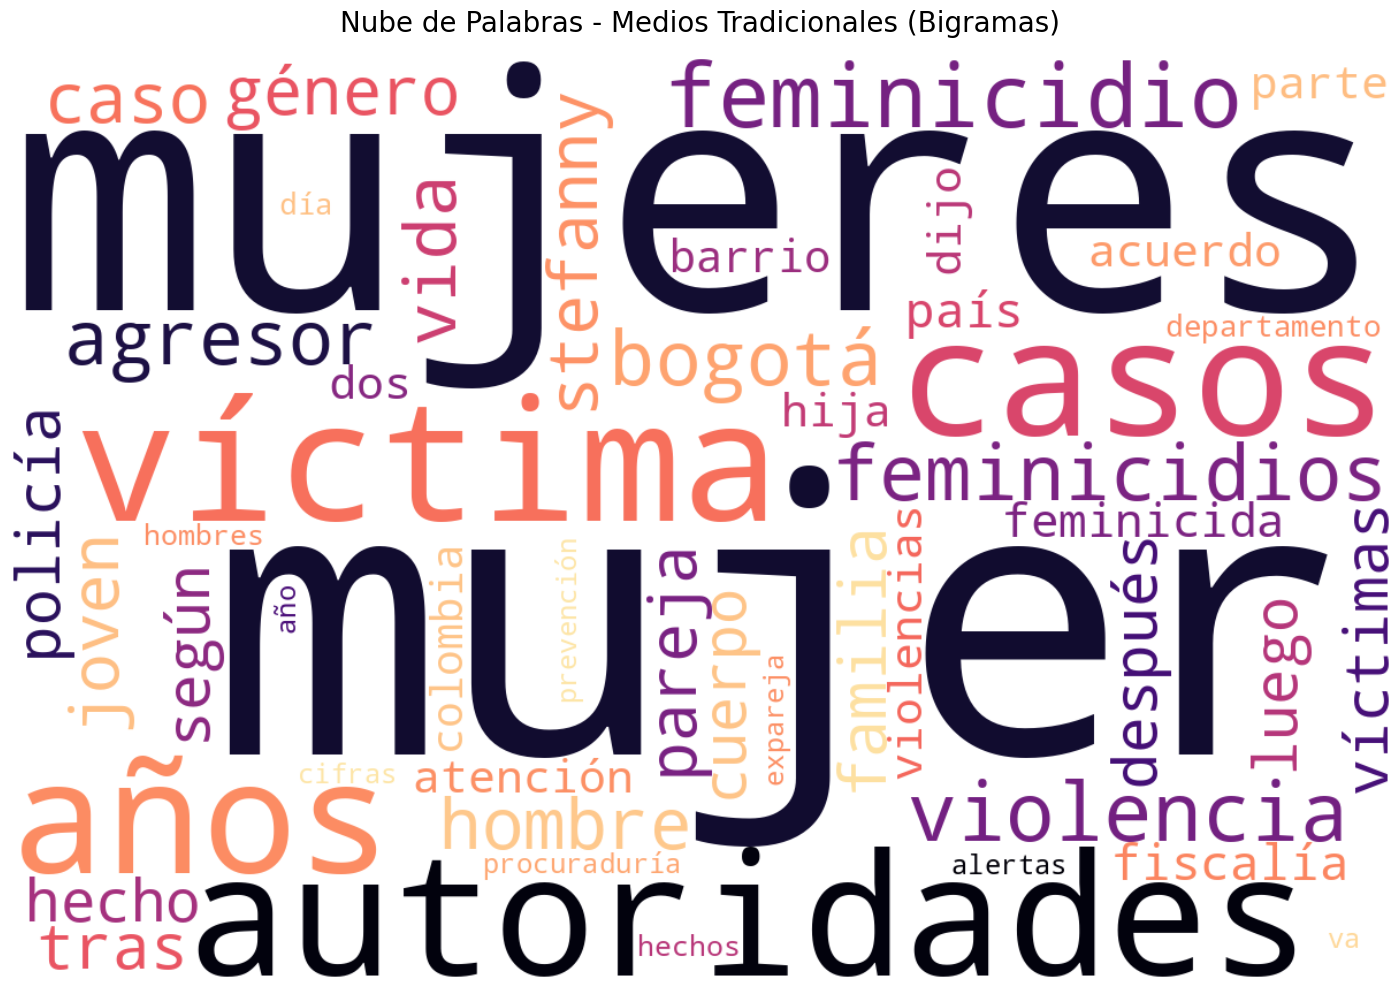

✓ Nube de palabras guardada como: nube_grupo1_bigramas.png


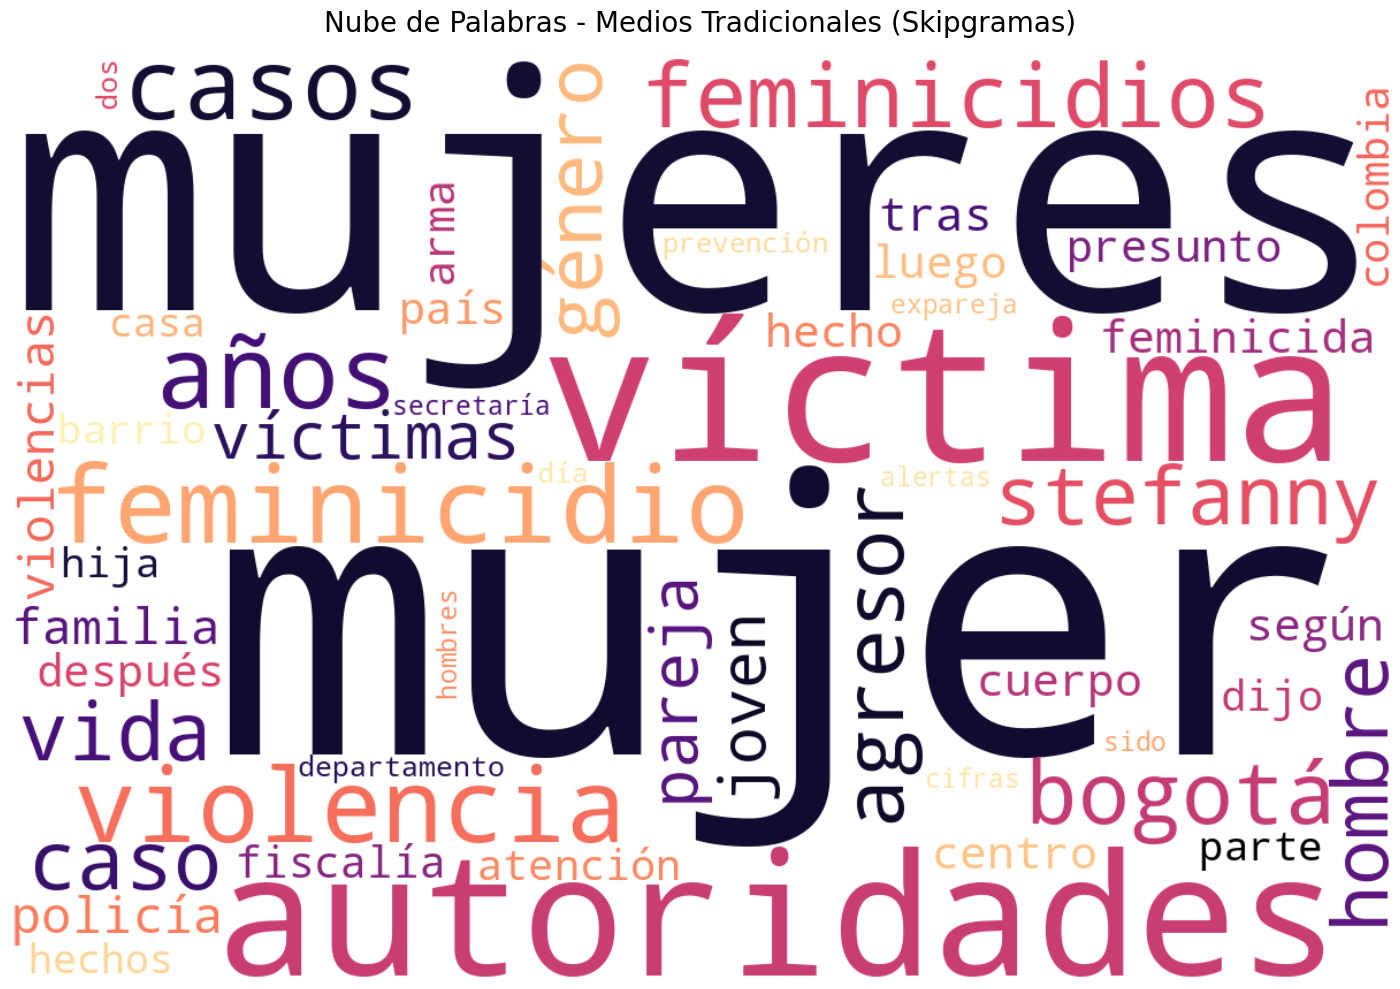

✓ Nube de palabras guardada como: nube_grupo1_skipgramas.png


🌈 PROCESANDO GRUPO 2: Medios feministas
✓ Leídas 25 palabras de La silla vacía
✓ Leídas 25 palabras de Casa de la mujer
✓ Leídas 25 palabras de Volcanicas
✓ Leídas 25 palabras de La silla vacía
✓ Leídas 25 palabras de Casa de la mujer
✓ Leídas 25 palabras de Volcanicas

ESTADÍSTICAS - GRUPO 2 - BIGRAMAS
Total de palabras únicas: 49
Centralidad máxima: 0.0780
Centralidad mínima: 0.0109
Centralidad promedio: 0.0256

Top 10 palabras más centrales:
 1. feminicidios    - 0.0780
 2. mujeres         - 0.0626
 3. feminicidio     - 0.0560
 4. mujer           - 0.0547
 5. autoridades     - 0.0416
 6. casos           - 0.0412
 7. violencia       - 0.0397
 8. años            - 0.0377
 9. mayo            - 0.0357
10. colombia        - 0.0344

ESTADÍSTICAS - GRUPO 2 - SKIPGRAMAS
Total de palabras únicas: 47
Centralidad máxima: 0.2063
Centralidad mínima: 0.0326
Centralidad promedio: 0.0756

Top 10 palabras más centrales:
 1. feminicidios 

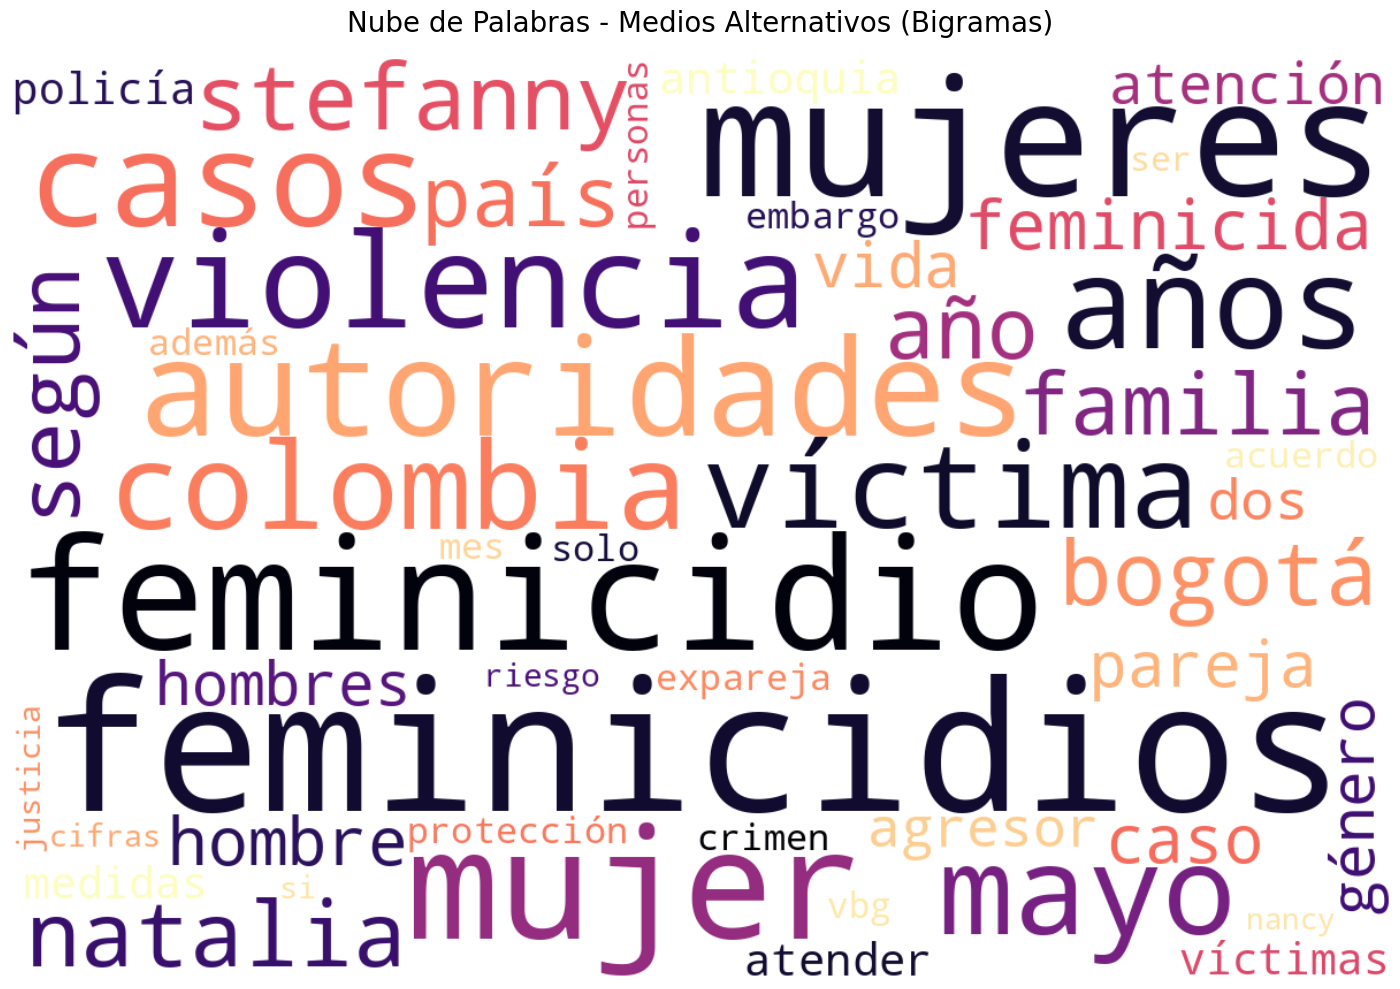

✓ Nube de palabras guardada como: nube_grupo2_bigramas.png


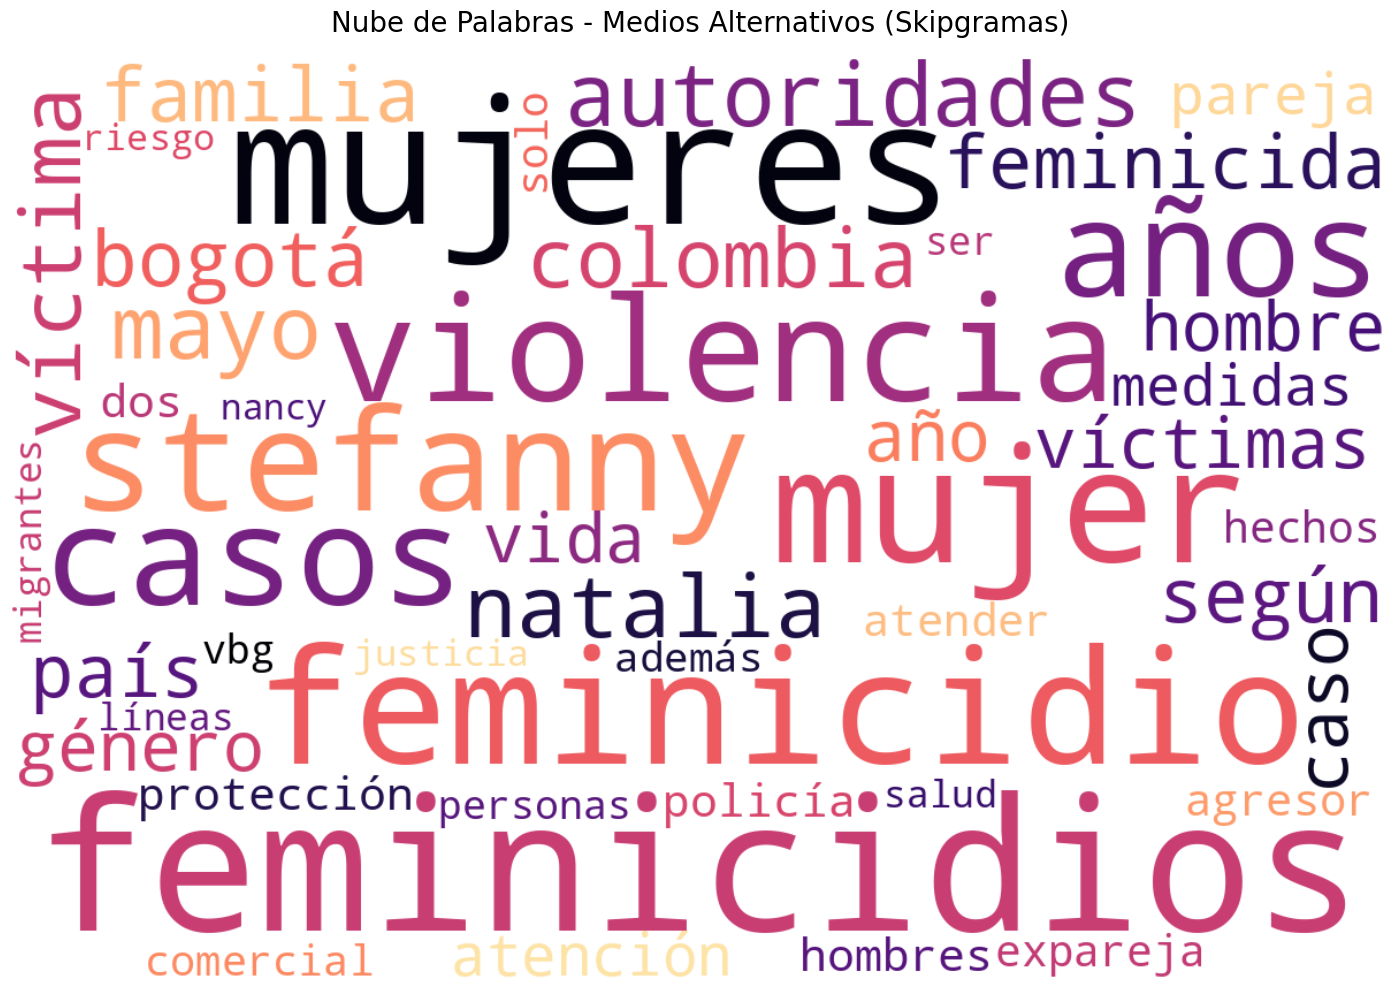

✓ Nube de palabras guardada como: nube_grupo2_skipgramas.png


📊 COMPARACIÓN ENTRE GRUPOS

Comparación Medios Tradicionales vs Medios Feministas:
Palabras comunes: 31
Palabras únicas en Medios Tradicionales: 19
Palabras únicas en Medios Feministas: 18

Ejemplos de palabras únicas en Medios Tradicionales:
alertas, dijo, cuerpo, departamento, procuraduría, después, hechos, barrio, tras, día

Ejemplos de palabras únicas en Medios Feministas:
medidas, antioquia, embargo, ser, mayo, vbg, si, crimen, justicia, natalia

✅ Generación de nubes de palabras completada!
📁 Las imágenes se han guardado en: /content/


In [119]:
# INSTALAR LIBRERÍAS NECESARIAS (si no están instaladas)
!pip install wordcloud matplotlib

# IMPORTAR LIBRERÍAS
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from collections import Counter
import pandas as pd

# CONFIGURACIÓN DE GRUPOS DE MEDIOS
grupo_tradicional = ['El tiempo', 'El espectador', 'Publimetro', 'El colombiano']
grupo_feminista = ['La silla vacía', 'Casa de la mujer', 'Volcanicas']

# FUNCIÓN PARA LEER CENTRALIDADES DE GRADO DESDE ARCHIVOS
def leer_centralidades_grado(carpeta_medio, tipo_grafo='bigrama'):
    """
    Lee las centralidades de grado desde los archivos de texto generados
    """
    centralidades = {}
    ruta_base = '/content/drive/MyDrive/Medios/Resultados_nodos_centrales_global'

    ruta_medio = os.path.join(ruta_base, carpeta_medio)
    archivo_centralidad = f'centralidad_Grado_{tipo_grafo}_{carpeta_medio}.txt'
    ruta_completa = os.path.join(ruta_medio, archivo_centralidad)

    try:
        with open(ruta_completa, 'r', encoding='utf-8') as f:
            for linea in f:
                if ':' in linea:
                    palabra, valor = linea.strip().split(': ')
                    centralidades[palabra] = float(valor)
        print(f"✓ Leídas {len(centralidades)} palabras de {carpeta_medio}")
        return centralidades
    except FileNotFoundError:
        print(f"✗ Archivo no encontrado: {ruta_completa}")
        return {}

# FUNCIÓN PARA COMBINAR CENTRALIDADES DE MÚLTIPLES MEDIOS
def combinar_centralidades_grupo(medios, tipo_grafo='bigrama'):
    """
    Combina las centralidades de grado de un grupo de medios
    """
    centralidades_combinadas = {}

    for medio in medios:
        centralidades_medio = leer_centralidades_grado(medio, tipo_grafo)

        for palabra, centralidad in centralidades_medio.items():
            if palabra in centralidades_combinadas:
                # Si la palabra ya existe, tomar la mayor centralidad
                centralidades_combinadas[palabra] = max(centralidades_combinadas[palabra], centralidad)
            else:
                centralidades_combinadas[palabra] = centralidad

    return centralidades_combinadas

# FUNCIÓN PARA CREAR NUBE DE PALABRAS
def crear_nube_palabras(centralidades, titulo, nombre_archivo, max_palabras=100):
    """
    Crea una nube de palabras a partir de las centralidades
    """
    if not centralidades:
        print(f"No hay datos para generar la nube de palabras: {titulo}")
        return

    # Filtrar las palabras más importantes
    palabras_filtradas = dict(sorted(centralidades.items(),
                                   key=lambda x: x[1],
                                   reverse=True)[:max_palabras])

    # Crear la nube de palabras
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        colormap='magma',
        max_words=max_palabras,
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(palabras_filtradas)

    # Configurar el gráfico
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=20, pad=20)
    plt.tight_layout()

    # Guardar la imagen
    plt.savefig(f'/content/{nombre_archivo}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Nube de palabras guardada como: {nombre_archivo}.png")

# FUNCIÓN PARA MOSTRAR ESTADÍSTICAS DEL GRUPO
def mostrar_estadisticas_grupo(centralidades, nombre_grupo):
    """
    Muestra estadísticas básicas de las centralidades de un grupo
    """
    if not centralidades:
        print(f"No hay datos para el grupo: {nombre_grupo}")
        return

    df = pd.DataFrame(list(centralidades.items()), columns=['Palabra', 'Centralidad'])

    print(f"\n{'='*50}")
    print(f"ESTADÍSTICAS - {nombre_grupo.upper()}")
    print(f"{'='*50}")
    print(f"Total de palabras únicas: {len(centralidades)}")
    print(f"Centralidad máxima: {df['Centralidad'].max():.4f}")
    print(f"Centralidad mínima: {df['Centralidad'].min():.4f}")
    print(f"Centralidad promedio: {df['Centralidad'].mean():.4f}")

    print(f"\nTop 10 palabras más centrales:")
    top_10 = df.nlargest(10, 'Centralidad')
    for i, (_, row) in enumerate(top_10.iterrows(), 1):
        print(f"{i:2d}. {row['Palabra']:15} - {row['Centralidad']:.4f}")

# EJECUTAR EL ANÁLISIS COMPLETO
print("INICIANDO GENERACIÓN DE NUBES DE PALABRAS POR GRUPOS")
print("=" * 60)

# GRUPO 1: Medios tradicionales
print("\n📰 PROCESANDO GRUPO 1: Medios tradicionales")
centralidades_grupo1_bigramas = combinar_centralidades_grupo(grupo_tradicional, 'bigrama')
centralidades_grupo1_skipgramas = combinar_centralidades_grupo(grupo_tradicional, 'skipgrama')

# Mostrar estadísticas
mostrar_estadisticas_grupo(centralidades_grupo1_bigramas, "Grupo 1 - Bigramas")
mostrar_estadisticas_grupo(centralidades_grupo1_skipgramas, "Grupo 1 - Skipgramas")

# Crear nubes de palabras para el grupo 1
crear_nube_palabras(
    centralidades_grupo1_bigramas,
    "Nube de Palabras - Medios Tradicionales (Bigramas)",
    "nube_grupo1_bigramas"
)

crear_nube_palabras(
    centralidades_grupo1_skipgramas,
    "Nube de Palabras - Medios Tradicionales (Skipgramas)",
    "nube_grupo1_skipgramas"
)

# GRUPO 2: Medios feministas
print("\n\n🌈 PROCESANDO GRUPO 2: Medios feministas")
centralidades_grupo2_bigramas = combinar_centralidades_grupo(grupo_feminista, 'bigrama')
centralidades_grupo2_skipgramas = combinar_centralidades_grupo(grupo_feminista, 'skipgrama')

# Mostrar estadísticas
mostrar_estadisticas_grupo(centralidades_grupo2_bigramas, "Grupo 2 - Bigramas")
mostrar_estadisticas_grupo(centralidades_grupo2_skipgramas, "Grupo 2 - Skipgramas")

# Crear nubes de palabras para el grupo 2
crear_nube_palabras(
    centralidades_grupo2_bigramas,
    "Nube de Palabras - Medios Alternativos (Bigramas)",
    "nube_grupo2_bigramas"
)

crear_nube_palabras(
    centralidades_grupo2_skipgramas,
    "Nube de Palabras - Medios Alternativos (Skipgramas)",
    "nube_grupo2_skipgramas"
)

# COMPARACIÓN ENTRE GRUPOS
print("\n\n📊 COMPARACIÓN ENTRE GRUPOS")
print("=" * 50)

def palabras_comunes_y_unicas(grupo1, grupo2, nombre_grupo1, nombre_grupo2):
    """
    Encuentra palabras comunes y únicas entre dos grupos
    """
    palabras_grupo1 = set(grupo1.keys())
    palabras_grupo2 = set(grupo2.keys())

    comunes = palabras_grupo1.intersection(palabras_grupo2)
    unicas_grupo1 = palabras_grupo1 - palabras_grupo2
    unicas_grupo2 = palabras_grupo2 - palabras_grupo1

    print(f"\nComparación {nombre_grupo1} vs {nombre_grupo2}:")
    print(f"Palabras comunes: {len(comunes)}")
    print(f"Palabras únicas en {nombre_grupo1}: {len(unicas_grupo1)}")
    print(f"Palabras únicas en {nombre_grupo2}: {len(unicas_grupo2)}")

    # Mostrar algunas palabras únicas de cada grupo
    if unicas_grupo1:
        print(f"\nEjemplos de palabras únicas en {nombre_grupo1}:")
        print(", ".join(list(unicas_grupo1)[:10]))

    if unicas_grupo2:
        print(f"\nEjemplos de palabras únicas en {nombre_grupo2}:")
        print(", ".join(list(unicas_grupo2)[:10]))

# Comparar bigramas
palabras_comunes_y_unicas(
    centralidades_grupo1_bigramas,
    centralidades_grupo2_bigramas,
    "Medios Tradicionales",
    "Medios Feministas"
)

print("\n✅ Generación de nubes de palabras completada!")
print("📁 Las imágenes se han guardado en: /content/")